In [11]:
from typing import Iterator, List, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
import os



In [2]:
import tensorflow_addons as tfa

In [3]:
dataset = ('C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2')

In [4]:
# Read the data
df = pd.io.parsers.read_csv(os.path.join(dataset, 'out.csv'))
# # Split data into training and validation sets
df_train, df_val = train_test_split(df, test_size=.2)

In [6]:
# df_train, df_test = train_test_split(
#         train, test_size=0.125, random_state=1
#     )  # split the data with an overall  test size of 10%

In [ ]:
y_hat = df_train["angle"].mean()
val["y_hat"] = y_hat
mae = MeanAbsoluteError()
mae = mae(val["angle"], val["y_hat"]).numpy()  # type: ignore
mape = MeanAbsolutePercentageError()
mape = mape(val["angle"], val["y_hat"]).numpy()  # type: ignore

print(mae)
print("mean baseline MAPE: ", mape)



In [6]:
datagen=ImageDataGenerator(rescale=1./255, 
        zoom_range=0.2,
        horizontal_flip=True,
        )


In [7]:
train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=dataset, x_col="File", y_col="angle", 
                                            class_mode="raw", target_size=(480,640), batch_size=32)

Found 4491 validated image filenames.


In [8]:
val_generator=datagen.flow_from_dataframe(dataframe=df_val, directory=dataset, x_col="File", y_col="angle", 
                                            class_mode="raw", target_size=(480,640), batch_size=32)

Found 1123 validated image filenames.


Found 2 validated image filenames.


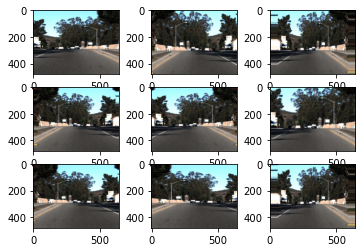

In [9]:
series = df.iloc[2]

df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()

iterator_visualizations = datagen.flow_from_dataframe(  # type: ignore
    dataframe=df_augmentation_visualization,
    directory = dataset,
    x_col="File",
    y_col="angle",
    class_mode="raw",
    target_size=(480, 640),  # size of the image
    batch_size=1,  # use only one image for visualization
)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
    img = batch[0]  # type: ignore
    img = img[0, :, :, :]  # remove one dimension for plotting without issues
    plt.imshow(img)
plt.show()
plt.close()

In [10]:
inputs = layers.Input(
        shape=(480, 640, 3)
    )  # input shapes of the images should always be 224x224x3 with EfficientNetB0
    # use the downloaded and converted newest EfficientNet wheights
model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")
# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(1, name="pred")(x)

# Compile
model = keras.Model(inputs, outputs, name="ResNet50")

In [10]:
radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-04)
optimizer   = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)


In [12]:
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-04), loss="mse", metrics=[MeanSquaredError()]
    )

# try with mse

In [13]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 240, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 240, 320, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

In [17]:
model_name = 'tl_regression_udacity'

In [15]:
callback1 = EarlyStopping(monitor="val_loss",
        #min_delta=1,  # model should improve by at least 1%
        patience=3)  # amount of epochs  with improvements worse than 1% until the model stops
        #verbose=2,
        #mode="min",
        #restore_best_weights=True) # restore the best model with the lowest validation error)
                          

In [18]:
logdir = (
        "logs/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  # create a folder for each model.
tensorboard_callback = TensorBoard(log_dir=logdir)


In [74]:
callback2 = ModelCheckpoint( "./models/" + model_name + ".h5",
        monitor="val_mean_absolute_percentage_error",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch") # save every epoch
    

In [19]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4, callbacks=[callback1, tensorboard_callback])

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/4
140/140 [==============================] - 1177s 8s/step - loss: 0.4152 - mean_squared_error: 0.4159 - val_loss: 0.0540 - val_mean_squared_error: 0.0540
Epoch 2/4
140/140 [==============================] - 1065s 8s/step - loss: 0.3178 - mean_squared_error: 0.3169 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 3/4
140/140 [==============================] - 1073s 8s/step - loss: 0.2903 - mean_squared_error: 0.2907 - val_loss: 0.0419 - val_mean_squared_error: 0.0419
Epoch 4/4
140/140 [==============================] - 1058s 8s/step - loss: 0.2599 - mean_squared_error: 0.2604 - val_loss: 0.0509 - val_mean_squared_error: 0.0509


In [20]:
model.save_weights('tl_regression_udacity_weights_v2.h5')

In [21]:
model.save('tl_regression_udacity_v2.h5')

In [24]:
from PIL import Image
import numpy as np
from keras.preprocessing import image
from keras.applications import inception_v3 as inc_net


In [25]:
def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  # create full path to image

        with Image.open(img_location) as img:  # open image with pillow

            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net
            img = inc_net.preprocess_input(img)

        images.append(img)
    images_array = np.vstack(images)  # combine images efficiently to a numpy array
    return images_array

In [26]:
images = open_images("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset")


In [27]:
predictions = model.predict_generator(images)

images_names = os.listdir("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset")
for image_name, prediction in zip(images_names, predictions):
    print(image_name, prediction)

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1479425719681268780.jpg [-1.5158184]
1479425719731264417.jpg [-1.6332499]
1479425719781262693.jpg [-1.663175]
1479425719831276356.jpg [-1.6326268]
1479425719881419974.jpg [-1.7497041]
1479425719931414543.jpg [-1.5862892]
1479425719981321507.jpg [-1.3703582]
1479425720031300599.jpg [-1.5052614]
1479425720081346893.jpg [-1.5172149]
1479425720131269683.jpg [-1.2927204]
1479425720181373910.jpg [-1.3487468]
1479425720231334733.jpg [-1.3348064]
1479425720281331591.jpg [-1.3910179]
1479425720331302374.jpg [-1.4667487]
1479425720381363046.jpg [-1.4841596]
1479425720431335470.jpg [-1.3003836]
1479425720481412110.jpg [-1.2972193]
1479425720531376518.jpg [-1.2022893]
1479425720581393603.jpg [-1.332018]
1479425720631398027.jpg [-1.1427352]
1479425720681517212.jpg [-1.1353256]
1479425720731420306.jpg [-1.3131008]
1479425720781425602.jpg [-1.398859]
1479425720831471166.jpg [-1.4279859]
1479425720881517725.jpg [-1.2815859]
1479425720931436208.jpg [-1.175889]
1479425720981458366.jpg [-1.1487141]
14794